In [1]:
import datetime
import sys
import time

from torch.autograd import Variable
from torch.utils.data import DataLoader
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.ticker import NullLocator

## Object Detection on the KITTI Dataset
## Agenda


## 1) KITTI Dataset

The KITTI car dataset is a well-known dataset used in the field of computer vision, particularly for autonomous driving research. It is part of the KITTI Vision Benchmark Suite, which was created by the Karlsruhe Institute of Technology and the Toyota Technological Institute at Chicago. The dataset includes various types of data collected from a car driving around a mid-size city, in rural areas, and on highways.

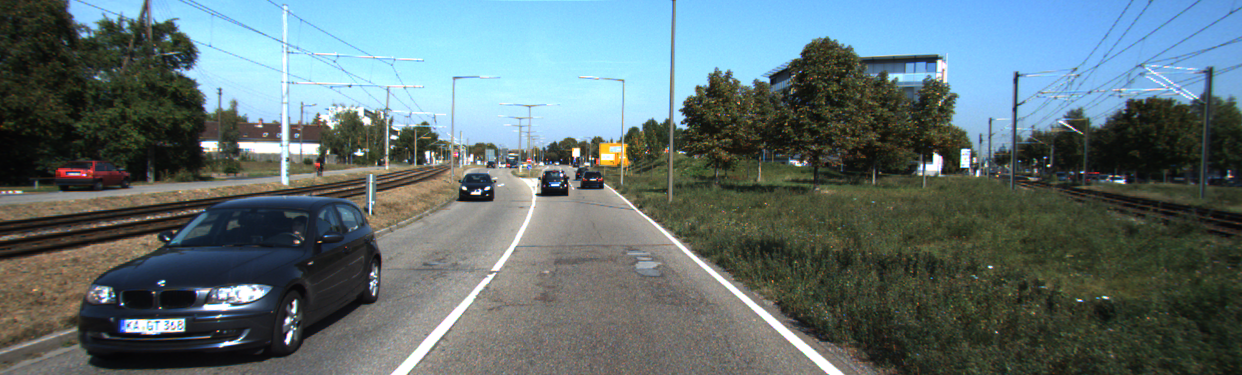

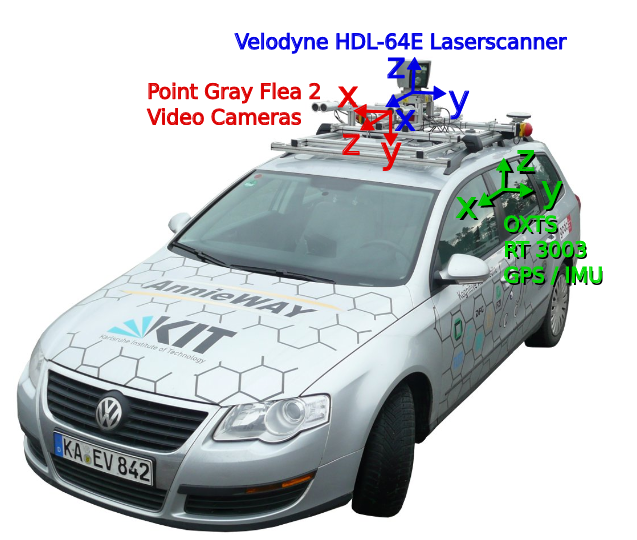


## 2) MiniKITTI hands-on

The Mini KITTI dataset is a smaller, simplified version of the original KITTI dataset designed to be more accessible and easier to use for quick experiments, educational purposes, and testing. It consists of 2D and 3D bounding boxes and reduced annotations. Overall its easier to download, process and use.

In [2]:
from utils.datasets import *
from utils.parse_config import *
from utils.utils import *
from utils.models import *
from evaluate import *

In [3]:
def transform_coordinates(xc,yc,w,h):
    x1 = xc-w/2
    y1 = yc-h/2
    return x1,y1,w,h

In [4]:
opt = dict()
opt["image_folder"] = "kitti-main/test.txt"
opt["class_path"] = "kitti-main/classes.names"
opt["batch_size"] = 1
opt["n_cpu"] = 8
opt["img_size"] = 350

In [5]:
classes = load_classes(opt["class_path"])  # Extracts class labels from file
print(classes)

['Car', 'Cyclist', 'Pedestrian', 'Van', 'Truck', 'Tram', 'Person_sitting']


In [6]:
dataloader = DataLoader(ListDataset(opt["image_folder"], img_size=opt["img_size"], transform=None,
                                        num_classes=int(len(classes)), multiscale=False),
                            batch_size=opt["batch_size"],
                            shuffle=False,
                            num_workers=opt["n_cpu"],
                            )

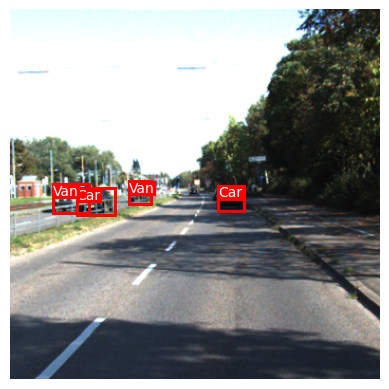

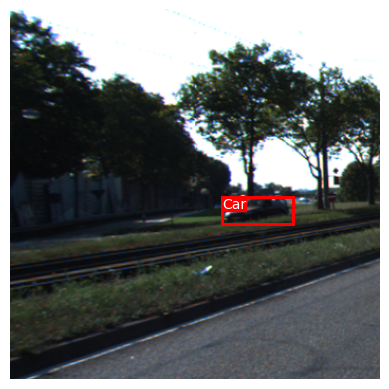

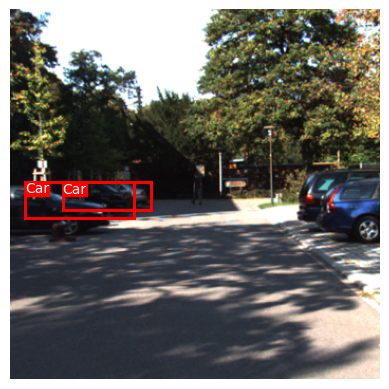

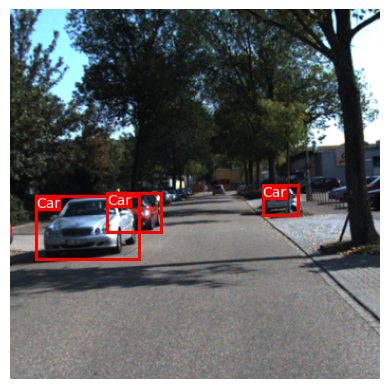

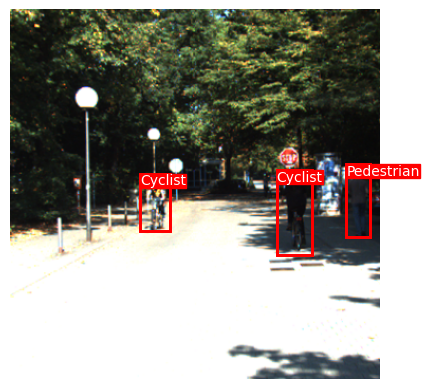

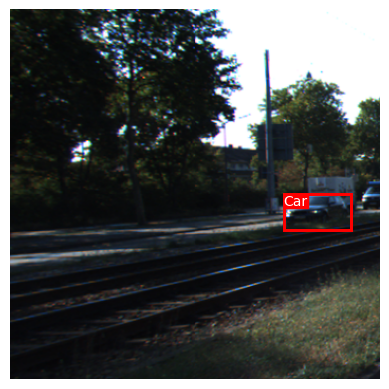

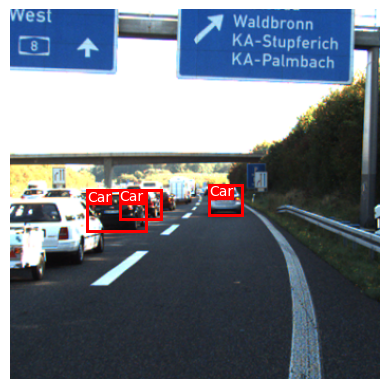

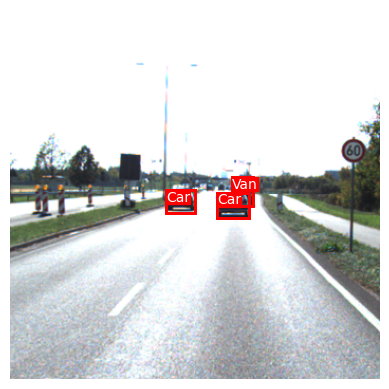

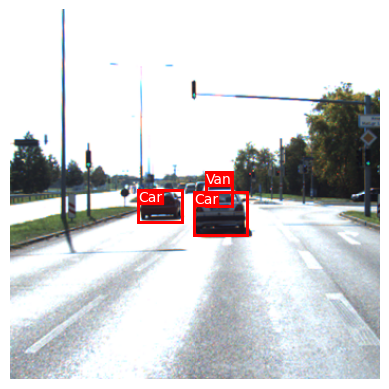

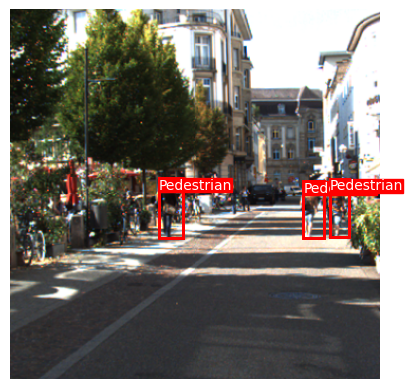

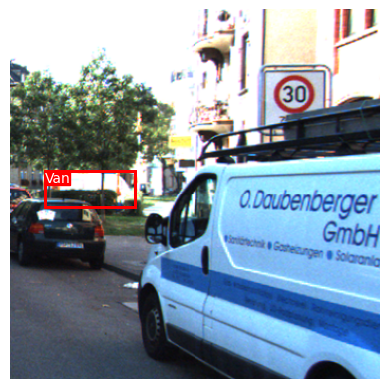

In [7]:
for batch_i, (img_paths, input_imgs, targets) in enumerate(dataloader):
    img = np.transpose(np.array(input_imgs[0]), (1,2,0))
    fig, axs = plt.subplots(1)
    axs.imshow(img)
    for target in targets[0]:
        cls = int(target[1])
        x1 = float(target[2]*opt["img_size"])
        y1 = float(target[3]*opt["img_size"])
        x2 = float(target[4]*opt["img_size"])
        y2 = float(target[5]*opt["img_size"])
        x1,y1,w,h = transform_coordinates(x1,y1,x2,y2)
        bbox = patches.Rectangle((x1,y1),w,h, linewidth=2, edgecolor="r", facecolor="none")
        
        # Add the bbox to the plot
        axs.add_patch(bbox)
        # Add label
        plt.text(
            x1,
            y1,
            s=classes[cls],
            color="white",
            verticalalignment="top",
            bbox={"color": 'red', "pad": 0},
        )
        plt.axis("off")
        plt.gca().xaxis.set_major_locator(NullLocator())
        plt.gca().yaxis.set_major_locator(NullLocator())
        axs.add_patch(bbox)
    if batch_i == 10:
        break


# SSD

The [SSD](https://arxiv.org/pdf/1512.02325) (Single Shot MultiBox Detector)  is a popular object detection model designed for high speed and accuracy in detecting objects within images. It is called "Single Shot" because it makes predictions directly from feature maps without requiring a separate region proposal stage, allowing it to perform detection in a single pass. The code was refactored from the [amdegroot](https://github.com/amdegroot/ssd.pytorch). 


## Multiple Aspect Ratios and Scales
SSD predicts bounding boxes and class scores for objects at multiple scales and aspect ratios from feature maps of different resolutions. This helps in detecting objects of various sizes.

![image.png](./notebook_figs/SSD.png)


## Network and Loss
SSD consists of only convolutional layers to predict both object classes and bounding box offsets from feature maps. It employs a combination of localization loss (e.g., smooth L1 loss) for bounding box regression and confidence loss (e.g., softmax loss) for class prediction. As given in the [paper](https://arxiv.org/pdf/1512.02325) we use VGG16 as the backbone network and additional conv layers (details in the config file) for the complete network.

![image.png](./notebook_figs/Network%20SSD.png)


In [10]:
opt = dict()
opt["image_folder"] = "kitti-main/test.txt"
opt["model_def"] = "config/ssd-kitti_1.00.cfg"
opt["weights_path"] = "SSD_Original.pth"
opt["class_path"] = "kitti-main/classes.names"
opt["batch_size"] = 1
opt["n_cpu"] = 8
opt["img_size"] = 300
opt["conf_thres"] = 0.8
opt["nms_thres"] = 0.4

for key in opt:
    print(f"{key}: {opt[key]}")

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

classes = load_classes(opt["class_path"])  # Extracts class labels from file

dataloader = DataLoader(ListDataset(opt["image_folder"], img_size=opt["img_size"], transform=None,
                                    num_classes=int(len(classes)), multiscale=False),
                        batch_size=opt["batch_size"],
                        shuffle=False,
                        num_workers=opt["n_cpu"],
                        )

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

print("\nPerforming object detection:")
prev_time = time.time()

os.makedirs("output_SSD_full", exist_ok=True)

# Set up model
model = SSD(opt["model_def"], num_classes=7).to(device)

# Load checkpoint weights
model.load_state_dict(torch.load(opt["weights_path"], map_location=torch.device("cuda:0")))

# Set in evaluation mode
model.eval()

image_folder: kitti-main/test.txt
model_def: config/ssd-kitti_1.00.cfg
weights_path: SSD_Original.pth
class_path: kitti-main/classes.names
batch_size: 1
n_cpu: 8
img_size: 300
conf_thres: 0.8
nms_thres: 0.4

Performing object detection:


SSD(
  (vgg): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (15): ReLU(i

In [11]:
imgs = [] #Stores images
imgs_paths = []  # Stores image paths
img_detections = []  # Stores detections for each image index

prev_time = time.time()
for batch_i, (img_paths, input_imgs, targets) in enumerate(dataloader):
    if batch_i > 100: break
    # Configure input
    
    input_imgs = Variable(input_imgs.type(Tensor))

    # Get detections
    with torch.no_grad():
        detections = model(input_imgs, 'eval')
        detections = non_max_suppression(detections, 0.4, nms_thres=0.8)

    # Log progress
    current_time = time.time()
    inference_time = datetime.timedelta(seconds=current_time - prev_time)
    prev_time = current_time
    print("\t+ Batch %d, Inference Time: %s" % (batch_i, inference_time))

    # Save image and detections
    imgs.append(input_imgs)
    imgs_paths.append(img_paths)
    img_detections.extend(detections) #(num_classes, top_k, 5)

    
print(f'len of imgs: {len(imgs)}')

precision, recall, AP, f1, ap_class = evaluate(
                    model,
                    path=opt['image_folder'],
                    iou_thres=0.5,
                    conf_thres=0.4,
                    nms_thres=0.5,
                    img_size=300,
                    batch_size=4,
                    num_classes=7,
                    model_type='ssd'
                )

print(f'Model Precision: {precision.mean():.2f}, Recall: {recall.mean():.2f}, AP: {AP.mean():.2f}, f1: {f1.mean():.2f}')


	+ Batch 0, Inference Time: 0:00:00.653678
	+ Batch 1, Inference Time: 0:00:00.044807
	+ Batch 2, Inference Time: 0:00:00.033109
	+ Batch 3, Inference Time: 0:00:00.033500
	+ Batch 4, Inference Time: 0:00:00.035945
	+ Batch 5, Inference Time: 0:00:00.034209
	+ Batch 6, Inference Time: 0:00:00.038830
	+ Batch 7, Inference Time: 0:00:00.039796
	+ Batch 8, Inference Time: 0:00:00.031626
	+ Batch 9, Inference Time: 0:00:00.033532
	+ Batch 10, Inference Time: 0:00:00.031949
	+ Batch 11, Inference Time: 0:00:00.037549
	+ Batch 12, Inference Time: 0:00:00.029831
	+ Batch 13, Inference Time: 0:00:00.035169
	+ Batch 14, Inference Time: 0:00:00.031259
	+ Batch 15, Inference Time: 0:00:00.029621
	+ Batch 16, Inference Time: 0:00:00.030016
	+ Batch 17, Inference Time: 0:00:00.037583
	+ Batch 18, Inference Time: 0:00:00.039846
	+ Batch 19, Inference Time: 0:00:00.033182
	+ Batch 20, Inference Time: 0:00:00.034848
	+ Batch 21, Inference Time: 0:00:00.030267
	+ Batch 22, Inference Time: 0:00:00.03088

Computing AP: 100%|██████████| 7/7 [00:00<00:00, 899.38it/s]

Model Precision: 0.79, Recall: 0.78, AP: 0.75, f1: 0.78


In [12]:
print(f'Number of detections processed: {len(img_detections)}')
# Bounding-box colors
cmap = plt.get_cmap("tab20b")
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

print("\nSaving images:")
# Iterate through images and save plot of detections
#print(f' img_detections[0]: {img_detections[0]}')
for img_i, (img_, path, detections) in enumerate(zip(imgs, imgs_paths, img_detections)):

    print("(%d) Image: '%s'" % (img_i, path))
    path = path[0]
    img_ = img_.squeeze(0)

    img = np.transpose(img_.detach().cpu().numpy(), (1,2,0))
    plt.figure()
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    # Draw bounding boxes and labels of detections
    if detections is not None:
        
        # Rescale boxes to original image
        print(detections[0], opt["img_size"], img.shape[:2])
        #detections = rescale_boxes(detections, opt["img_size"], img.shape[:2])
        unique_labels = detections[:, -1].cpu().unique()
        n_cls_preds = len(unique_labels)
        bbox_colors = random.sample(colors, n_cls_preds)
        for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:

            print("\t+ Label: %s, Conf: %.5f" % (classes[int(cls_pred)], cls_conf.item()))

            box_w = x2 - x1
            box_h = y2 - y1

            color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
            # Create a Rectangle patch
            bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor="none")
            # Add the bbox to the plot
            ax.add_patch(bbox)
            # Add label
            plt.text(
                x1,
                y1,
                s=classes[int(cls_pred)],
                color="white",
                verticalalignment="top",
                bbox={"color": color, "pad": 0},
            )

    # Save generated image with detections
    plt.axis("off")
    plt.gca().xaxis.set_major_locator(NullLocator())
    plt.gca().yaxis.set_major_locator(NullLocator())
    filename = os.path.basename(path).split(".")[0]
    
    output_path = os.path.join("output_SSD", f"{filename}.png")
    plt.savefig(output_path, bbox_inches="tight", pad_inches=0.0)
    plt.close()

Number of detections processed: 101

Saving images:
(0) Image: '('/home/kartik/Desktop/ADS/Softwareentwick 950733395 (S24)_2024072_1714/04 - Detection (14.05)/YOLOV3_SSD/kitti-main/images/test/007423.png',)'
tensor([ 49.9123, 142.5345,  84.4524, 167.9695,   0.9996,   1.0000,   0.0000]) 300 (300, 300)
	+ Label: Car, Conf: 1.00000
	+ Label: Van, Conf: 1.00000
	+ Label: Car, Conf: 0.82096
(1) Image: '('/home/kartik/Desktop/ADS/Softwareentwick 950733395 (S24)_2024072_1714/04 - Detection (14.05)/YOLOV3_SSD/kitti-main/images/test/021615.png',)'
tensor([170.9461, 149.0695, 227.6079, 177.4162,   0.9763,   1.0000,   0.0000]) 300 (300, 300)
	+ Label: Car, Conf: 1.00000
	+ Label: Car, Conf: 0.50420
(2) Image: '('/home/kartik/Desktop/ADS/Softwareentwick 950733395 (S24)_2024072_1714/04 - Detection (14.05)/YOLOV3_SSD/kitti-main/images/test/017164.png',)'
tensor([ 26.2083, 134.9077, 105.8850, 167.8005,   0.9676,   1.0000,   0.0000]) 300 (300, 300)
	+ Label: Car, Conf: 1.00000
	+ Label: Car, Conf: 0.4

/tmp/ipykernel_9360/3388031099.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1)
/tmp/ipykernel_9360/3388031099.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


(20) Image: '('/home/kartik/Desktop/ADS/Softwareentwick 950733395 (S24)_2024072_1714/04 - Detection (14.05)/YOLOV3_SSD/kitti-main/images/test/005588.png',)'
tensor([132.4380, 124.5354, 231.1664, 296.9263,   0.9683,   1.0000,   2.0000]) 300 (300, 300)
	+ Label: Pedestrian, Conf: 1.00000
	+ Label: Pedestrian, Conf: 0.99999
	+ Label: Pedestrian, Conf: 0.97093
	+ Label: Pedestrian, Conf: 0.77445
	+ Label: Pedestrian, Conf: 0.59781
	+ Label: Pedestrian, Conf: 0.40350
	+ Label: Pedestrian, Conf: 0.36653
	+ Label: Pedestrian, Conf: 0.30995
	+ Label: Pedestrian, Conf: 0.24575
(21) Image: '('/home/kartik/Desktop/ADS/Softwareentwick 950733395 (S24)_2024072_1714/04 - Detection (14.05)/YOLOV3_SSD/kitti-main/images/test/017157.png',)'
tensor([172.6470, 124.0786, 274.4484, 170.8925,   0.9915,   1.0000,   4.0000]) 300 (300, 300)
	+ Label: Truck, Conf: 1.00000
	+ Label: Car, Conf: 1.00000
	+ Label: Car, Conf: 0.97311
	+ Label: Truck, Conf: 0.39814
	+ Label: Truck, Conf: 0.26251
(22) Image: '('/home/ka

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

# YOLO v3

[YOLOv3](https://arxiv.org/pdf/1804.02767) (You Only Look Once version 3) is a state-of-the-art, real-time object detection system that improves upon previous versions (YOLO and YOLOv2) in terms of both speed and accuracy. It is widely known for its efficiency and effectiveness in detecting objects within images.

YOLOv3, like its predecessors, performs object detection in a single stage by directly predicting bounding boxes and class probabilities from full images in one evaluation, without the need for a separate region proposal stage, similar to SSD.

![image.png](./notebook_figs/YOLO.png)

## Multi-Scale Predictions

YOLOv3 makes predictions at three different scales. This is achieved by extracting feature maps from three different layers of the network, which helps in detecting objects of various sizes effectively.

![image.png](./notebook_figs/Multi-Scale%20YOLO.png)

## Network and Loss
YOLOv3 uses a new backbone network called Darknet-53, which consists of 53 convolutional layers and is more powerful and efficient compared to the previous backbone used in YOLOv2. It employs residual connections similar to those in ResNet, enhancing feature extraction capabilities.

It uses predefined anchor boxes (similar to SSD) at each grid cell for predicting bounding boxes. These anchor boxes are adjusted based on the predicted offsets to match the detected objects.

For each bounding box, YOLOv3 predicts four coordinates (center x, center y, width, height), an objectness score (indicating the presence of an object), and class probabilities.

Binary cross-entropy loss is used for both class prediction and objectness score, which improves the stability and convergence of the training process.

![image.png](./notebook_figs/YOLO%20Network.png)

In [13]:
opt["model_def"] = "./config/yolov3-kitti-tiny_7cls.cfg"
opt["weights_path"] = "yolov3_tiny.pth"
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.makedirs("output_YOLO", exist_ok=True)

# Set up model
model = Darknet(opt["model_def"], img_size=300).to(device)

# Load checkpoint weights
model.load_state_dict(torch.load(opt["weights_path"], map_location=torch.device("cuda")))

# Set in evaluation mode
model.eval()

Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(16, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (maxpool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (conv_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (maxpool_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (4): Sequential(
      (conv_4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_4): BatchNorm2d(64, eps=1e-05, momentum=0.9, aff

In [14]:

imgs = [] #Stores images
imgs_paths = []  # Stores image paths
img_detections = []  # Stores detections for each image index

prev_time = time.time()
for batch_i, (img_paths, input_imgs, targets) in enumerate(dataloader):

    if batch_i == 100:
        break
    # Configure input
    input_imgs = Variable(input_imgs.type(Tensor))

    # Get detections
    with torch.no_grad():
        
        detections = model(input_imgs)
        detections = non_max_suppression(detections, opt["conf_thres"], opt["nms_thres"])
        
    # Log progress
    current_time = time.time()
    inference_time = datetime.timedelta(seconds=current_time - prev_time)
    prev_time = current_time
    print("\t+ Batch %d, Inference Time: %s" % (batch_i, inference_time))

    # Save image and detections
    imgs.extend(input_imgs)
    imgs_paths.extend(img_paths)
    img_detections.extend(detections)

    
print(f'len of imgs: {len(imgs)}')

precision, recall, AP, f1, ap_class = evaluate(
                    model,
                    path=opt['image_folder'],
                    iou_thres=0.5,
                    conf_thres=0.5,
                    nms_thres=0.5,
                    img_size=300,
                    batch_size=4,
                    num_classes=7,
                    model_type='yolov3'
                )

print(f'Model Precision: {precision.mean():.2f}, Recall: {recall.mean():.2f}, AP: {AP.mean():.2f}, f1: {f1.mean():.2f}')


/home/kartik/Desktop/ADS/Softwareentwick 950733395 (S24)_2024072_1714/04 - Detection (14.05)/YOLOV3_SSD/utils/models.py:129: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:78.)
  self.scaled_anchors = FloatTensor([(a_w / self.stride, a_h / self.stride) for a_w, a_h in self.anchors])


	+ Batch 0, Inference Time: 0:00:00.822828
	+ Batch 1, Inference Time: 0:00:00.009146
	+ Batch 2, Inference Time: 0:00:00.009548
	+ Batch 3, Inference Time: 0:00:00.019287
	+ Batch 4, Inference Time: 0:00:00.011527
	+ Batch 5, Inference Time: 0:00:00.012632
	+ Batch 6, Inference Time: 0:00:00.012651
	+ Batch 7, Inference Time: 0:00:00.009168
	+ Batch 8, Inference Time: 0:00:00.008995
	+ Batch 9, Inference Time: 0:00:00.008774
	+ Batch 10, Inference Time: 0:00:00.009129
	+ Batch 11, Inference Time: 0:00:00.007791
	+ Batch 12, Inference Time: 0:00:00.009768
	+ Batch 13, Inference Time: 0:00:00.008838
	+ Batch 14, Inference Time: 0:00:00.013947
	+ Batch 15, Inference Time: 0:00:00.007959
	+ Batch 16, Inference Time: 0:00:00.008933
	+ Batch 17, Inference Time: 0:00:00.010234
	+ Batch 18, Inference Time: 0:00:00.008587
	+ Batch 19, Inference Time: 0:00:00.015224
	+ Batch 20, Inference Time: 0:00:00.012074
	+ Batch 21, Inference Time: 0:00:00.011303
	+ Batch 22, Inference Time: 0:00:00.01151

Computing AP: 100%|██████████| 7/7 [00:00<00:00, 644.85it/s]

Model Precision: 0.64, Recall: 0.67, AP: 0.59, f1: 0.66


In [15]:
# Bounding-box colors
cmap = plt.get_cmap("tab20b")
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

print("\nSaving images:")
# Iterate through images and save plot of detections
for img_i, (img_, path, detections) in enumerate(zip(imgs, imgs_paths, img_detections)):

    print("(%d) Image: '%s'" % (img_i, path))

    # Create plot
    #img = np.array(Image.open(path))
    img = np.transpose(img_.detach().cpu().numpy(), (1,2,0))
    plt.figure()
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    print(f'img shape: {img.shape}')

    # Draw bounding boxes and labels of detections
    if detections is not None:
        # Rescale boxes to original image
        print(detections[0], opt["img_size"], img.shape[:2])
        detections = rescale_boxes(detections, opt["img_size"], img.shape[:2])
        unique_labels = detections[:, -1].cpu().unique()
        n_cls_preds = len(unique_labels)
        bbox_colors = random.sample(colors, n_cls_preds)
        for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:

            print("\t+ Label: %s, Conf: %.5f" % (classes[int(cls_pred)], cls_conf.item()))

            box_w = x2 - x1
            box_h = y2 - y1

            color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
            # Create a Rectangle patch
            bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor="none")
            # Add the bbox to the plot
            ax.add_patch(bbox)
            # Add label
            plt.text(
                x1,
                y1,
                s=classes[int(cls_pred)],
                color="white",
                verticalalignment="top",
                bbox={"color": color, "pad": 0},
            )

    # Save generated image with detections
    plt.axis("off")
    plt.gca().xaxis.set_major_locator(NullLocator())
    plt.gca().yaxis.set_major_locator(NullLocator())
    filename = os.path.basename(path).split(".")[0]
    
    output_path = os.path.join("output_YOLO", f"{filename}.png")
    plt.savefig(output_path, bbox_inches="tight", pad_inches=0.0)
    plt.close()


Saving images:
(0) Image: '/home/kartik/Desktop/ADS/Softwareentwick 950733395 (S24)_2024072_1714/04 - Detection (14.05)/YOLOV3_SSD/kitti-main/images/test/007423.png'
img shape: (300, 300, 3)
tensor([167.9101, 141.2785, 191.0817, 163.1679,   0.9993,   1.0000,   0.0000]) 300 (300, 300)
	+ Label: Car, Conf: 0.99996
	+ Label: Van, Conf: 0.88844
	+ Label: Car, Conf: 0.70279
(1) Image: '/home/kartik/Desktop/ADS/Softwareentwick 950733395 (S24)_2024072_1714/04 - Detection (14.05)/YOLOV3_SSD/kitti-main/images/test/021615.png'
img shape: (300, 300, 3)
tensor([164.9794, 153.4204, 223.5245, 172.7776,   0.8212,   0.9984,   0.0000]) 300 (300, 300)
	+ Label: Car, Conf: 0.99840
(2) Image: '/home/kartik/Desktop/ADS/Softwareentwick 950733395 (S24)_2024072_1714/04 - Detection (14.05)/YOLOV3_SSD/kitti-main/images/test/017164.png'
img shape: (300, 300, 3)
(3) Image: '/home/kartik/Desktop/ADS/Softwareentwick 950733395 (S24)_2024072_1714/04 - Detection (14.05)/YOLOV3_SSD/kitti-main/images/test/000127.png'
i

/tmp/ipykernel_9360/2042738588.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1)
/tmp/ipykernel_9360/2042738588.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


img shape: (300, 300, 3)
tensor([120.8885, 102.2879, 260.9992, 313.5130,   0.8422,   0.9046,   2.0000]) 300 (300, 300)
	+ Label: Pedestrian, Conf: 0.90464
(21) Image: '/home/kartik/Desktop/ADS/Softwareentwick 950733395 (S24)_2024072_1714/04 - Detection (14.05)/YOLOV3_SSD/kitti-main/images/test/017157.png'
img shape: (300, 300, 3)
(22) Image: '/home/kartik/Desktop/ADS/Softwareentwick 950733395 (S24)_2024072_1714/04 - Detection (14.05)/YOLOV3_SSD/kitti-main/images/test/015783.png'
img shape: (300, 300, 3)
tensor([156.9029, 146.2101, 270.7771, 191.3529,   0.8745,   0.9986,   0.0000]) 300 (300, 300)
	+ Label: Car, Conf: 0.99859
(23) Image: '/home/kartik/Desktop/ADS/Softwareentwick 950733395 (S24)_2024072_1714/04 - Detection (14.05)/YOLOV3_SSD/kitti-main/images/test/020502.png'
img shape: (300, 300, 3)
(24) Image: '/home/kartik/Desktop/ADS/Softwareentwick 950733395 (S24)_2024072_1714/04 - Detection (14.05)/YOLOV3_SSD/kitti-main/images/test/012889.png'
img shape: (300, 300, 3)
tensor([165.23

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

## Evaluation metrics of Pruned SSD networks

After having pruned the SSD network via L2 norm weight magnitude metric, we now compare these models based on their AP and run-time on the KITTI test set. Each model was pruned for the first few epochs and then trained further, all in 20 epochs.

In [24]:
ssd_model_list = ['Original', 'compressed_0.50', 'compressed_0.40', 
              'compressed_0.32', 'compressed_0.26', 'compressed_0.14', 'compressed_0.11']

ssd_model_configs = ['_1.00', '_0.50', '_0.40', '_0.32', '_0.26', '_0.14', '_0.11']

In [25]:
import datetime

F1_stats = {}
AP_stats = {}
run_time_stats = {}
num_sims = 10
for sim_i in range(num_sims):
    print(f'Sim: {sim_i}')
    for ssd_model, model_config in zip(ssd_model_list, ssd_model_configs):
        if sim_i == 0:
            F1_stats[ssd_model] = []
            AP_stats[ssd_model] = []
            run_time_stats[ssd_model] = []

        print(f'Evaluating SSD_{ssd_model}.pth, config: {model_config}')
        model = SSD(f'config/ssd-kitti{model_config}.cfg', num_classes=7).to('cuda:0')
        model.load_state_dict(torch.load(f'SSD_{ssd_model}.pth', map_location=torch.device('cuda:0')))
        start = datetime.datetime.now()
        
        precision, recall, AP, f1, ap_class = evaluate(
                        model,
                        path='kitti-main/test.txt',
                        iou_thres=0.5,
                        conf_thres=0.5,
                        nms_thres=0.5,
                        img_size=300,
                        batch_size=4,
                        num_classes=7,
                        model_type='ssd'
                    )
        end = datetime.datetime.now()
        F1_stats[ssd_model].append(f1.mean())
        AP_stats[ssd_model].append(AP.mean())
        time_diff = end-start
        run_time_stats[ssd_model].append(time_diff.total_seconds() * 1000) #milliseconds

    if sim_i==0:
        F1_stats['yolov3_tiny'] = []
        AP_stats['yolov3_tiny'] = []
        run_time_stats['yolov3_tiny'] = []

    print(f'Evaluating YOLOV3')
    model = Darknet(f'config/yolov3-kitti-tiny_7cls.cfg', img_size=300).to('cuda:0')
    model.load_state_dict(torch.load(f'yolov3_tiny.pth', map_location=torch.device('cuda:0')))
    start = datetime.datetime.now()

    precision, recall, AP, f1, ap_class = evaluate(
                        model,
                        path='kitti-main/test.txt',
                        iou_thres=0.5,
                        conf_thres=0.5,
                        nms_thres=0.5,
                        img_size=300,
                        batch_size=4,
                        num_classes=7,
                        model_type='yolov3'
                    )
    end = datetime.datetime.now()
    time_diff = end - start
    F1_stats['yolov3_tiny'].append(f1.mean())
    AP_stats['yolov3_tiny'].append(AP.mean())
    run_time_stats['yolov3_tiny'].append(time_diff.total_seconds() * 1000)



f1_scores = []
AP_scores = []
run_times = []
for ssd_model in ssd_model_list:
    F1_stats[ssd_model] = round(np.array(F1_stats[ssd_model]).mean(), 2) 
    AP_stats[ssd_model] = round(np.array(AP_stats[ssd_model]).mean(), 2)
    run_time_stats[ssd_model] = round(np.array(run_time_stats[ssd_model]).mean(), 2)

F1_stats['yolov3_tiny'] = round(np.array(F1_stats['yolov3_tiny']).mean(), 2)
AP_stats['yolov3_tiny'] = round(np.array(AP_stats['yolov3_tiny']).mean(), 2)
run_time_stats['yolov3_tiny'] = round(np.array(run_time_stats['yolov3_tiny']).mean(), 2)

print(f'F1_stats: {F1_stats}')
print(f'AP_stats: {AP_stats}')
print(f'run_time_stats: {run_time_stats}')


Sim: 0
Evaluating SSD_Original.pth, config: _1.00


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 925.63it/s]


Evaluating SSD_compressed_0.50.pth, config: _0.50


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 622.18it/s]


Evaluating SSD_compressed_0.40.pth, config: _0.40


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 406.45it/s]


Evaluating SSD_compressed_0.32.pth, config: _0.32


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 215.87it/s]


Evaluating SSD_compressed_0.26.pth, config: _0.26


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 772.15it/s]


Evaluating SSD_compressed_0.14.pth, config: _0.14


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 480.78it/s]


Evaluating SSD_compressed_0.11.pth, config: _0.11


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 745.65it/s]


Evaluating YOLOV3


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 457.80it/s]


Sim: 1
Evaluating SSD_Original.pth, config: _1.00


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 296.83it/s]


Evaluating SSD_compressed_0.50.pth, config: _0.50


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 291.77it/s]


Evaluating SSD_compressed_0.40.pth, config: _0.40


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 274.80it/s]


Evaluating SSD_compressed_0.32.pth, config: _0.32


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 288.56it/s]


Evaluating SSD_compressed_0.26.pth, config: _0.26


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 480.79it/s]


Evaluating SSD_compressed_0.14.pth, config: _0.14


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 296.30it/s]


Evaluating SSD_compressed_0.11.pth, config: _0.11


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 605.86it/s]


Evaluating YOLOV3


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 430.30it/s]


Sim: 2
Evaluating SSD_Original.pth, config: _1.00


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 537.64it/s]


Evaluating SSD_compressed_0.50.pth, config: _0.50


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 378.03it/s]


Evaluating SSD_compressed_0.40.pth, config: _0.40


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 402.78it/s]


Evaluating SSD_compressed_0.32.pth, config: _0.32


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 356.16it/s]


Evaluating SSD_compressed_0.26.pth, config: _0.26


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 319.91it/s]


Evaluating SSD_compressed_0.14.pth, config: _0.14


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 558.56it/s]


Evaluating SSD_compressed_0.11.pth, config: _0.11


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 351.40it/s]


Evaluating YOLOV3


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 314.54it/s]


Sim: 3
Evaluating SSD_Original.pth, config: _1.00


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 280.79it/s]


Evaluating SSD_compressed_0.50.pth, config: _0.50


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 411.58it/s]


Evaluating SSD_compressed_0.40.pth, config: _0.40


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 438.87it/s]


Evaluating SSD_compressed_0.32.pth, config: _0.32


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 286.42it/s]


Evaluating SSD_compressed_0.26.pth, config: _0.26


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 331.12it/s]


Evaluating SSD_compressed_0.14.pth, config: _0.14


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 445.05it/s]


Evaluating SSD_compressed_0.11.pth, config: _0.11


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 500.20it/s]


Evaluating YOLOV3


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 400.55it/s]


Sim: 4
Evaluating SSD_Original.pth, config: _1.00


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 318.45it/s]


Evaluating SSD_compressed_0.50.pth, config: _0.50


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 263.00it/s]


Evaluating SSD_compressed_0.40.pth, config: _0.40


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 217.76it/s]


Evaluating SSD_compressed_0.32.pth, config: _0.32


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 379.73it/s]


Evaluating SSD_compressed_0.26.pth, config: _0.26


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 176.00it/s]


Evaluating SSD_compressed_0.14.pth, config: _0.14


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 396.13it/s]


Evaluating SSD_compressed_0.11.pth, config: _0.11


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 599.31it/s]


Evaluating YOLOV3


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 652.84it/s]


Sim: 5
Evaluating SSD_Original.pth, config: _1.00


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 270.46it/s]


Evaluating SSD_compressed_0.50.pth, config: _0.50


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 305.62it/s]


Evaluating SSD_compressed_0.40.pth, config: _0.40


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 475.61it/s]


Evaluating SSD_compressed_0.32.pth, config: _0.32


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 242.24it/s]


Evaluating SSD_compressed_0.26.pth, config: _0.26


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 282.90it/s]


Evaluating SSD_compressed_0.14.pth, config: _0.14


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 404.25it/s]


Evaluating SSD_compressed_0.11.pth, config: _0.11


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 233.51it/s]


Evaluating YOLOV3


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 464.46it/s]


Sim: 6
Evaluating SSD_Original.pth, config: _1.00


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 334.91it/s]


Evaluating SSD_compressed_0.50.pth, config: _0.50


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 317.37it/s]


Evaluating SSD_compressed_0.40.pth, config: _0.40


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 453.17it/s]


Evaluating SSD_compressed_0.32.pth, config: _0.32


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 456.95it/s]


Evaluating SSD_compressed_0.26.pth, config: _0.26


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 355.10it/s]


Evaluating SSD_compressed_0.14.pth, config: _0.14


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 400.82it/s]


Evaluating SSD_compressed_0.11.pth, config: _0.11


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 346.83it/s]


Evaluating YOLOV3


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 433.78it/s]


Sim: 7
Evaluating SSD_Original.pth, config: _1.00


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 541.77it/s]


Evaluating SSD_compressed_0.50.pth, config: _0.50


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 416.80it/s]


Evaluating SSD_compressed_0.40.pth, config: _0.40


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 214.60it/s]


Evaluating SSD_compressed_0.32.pth, config: _0.32


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 482.52it/s]


Evaluating SSD_compressed_0.26.pth, config: _0.26


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 265.85it/s]


Evaluating SSD_compressed_0.14.pth, config: _0.14


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 347.07it/s]


Evaluating SSD_compressed_0.11.pth, config: _0.11


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 824.88it/s]


Evaluating YOLOV3


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 475.49it/s]


Sim: 8
Evaluating SSD_Original.pth, config: _1.00


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 309.16it/s]


Evaluating SSD_compressed_0.50.pth, config: _0.50


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 176.67it/s]


Evaluating SSD_compressed_0.40.pth, config: _0.40


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 250.66it/s]


Evaluating SSD_compressed_0.32.pth, config: _0.32


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 276.81it/s]


Evaluating SSD_compressed_0.26.pth, config: _0.26


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 378.06it/s]


Evaluating SSD_compressed_0.14.pth, config: _0.14


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 694.52it/s]


Evaluating SSD_compressed_0.11.pth, config: _0.11


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 882.48it/s]


Evaluating YOLOV3


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 275.44it/s]


Sim: 9
Evaluating SSD_Original.pth, config: _1.00


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 257.78it/s]


Evaluating SSD_compressed_0.50.pth, config: _0.50


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 228.77it/s]


Evaluating SSD_compressed_0.40.pth, config: _0.40


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 259.83it/s]


Evaluating SSD_compressed_0.32.pth, config: _0.32


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 532.20it/s]


Evaluating SSD_compressed_0.26.pth, config: _0.26


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 427.45it/s]


Evaluating SSD_compressed_0.14.pth, config: _0.14


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 661.20it/s]


Evaluating SSD_compressed_0.11.pth, config: _0.11


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 381.35it/s]


Evaluating YOLOV3


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 384.71it/s]

F1_stats: {'Original': 0.79, 'compressed_0.50': 0.74, 'compressed_0.40': 0.76, 'compressed_0.32': 0.74, 'compressed_0.26': 0.66, 'compressed_0.14': 0.67, 'compressed_0.11': 0.54, 'yolov3_tiny': 0.66}
AP_stats: {'Original': 0.73, 'compressed_0.50': 0.68, 'compressed_0.40': 0.71, 'compressed_0.32': 0.72, 'compressed_0.26': 0.6, 'compressed_0.14': 0.57, 'compressed_0.11': 0.48, 'yolov3_tiny': 0.59}
run_time_stats: {'Original': 50398.84, 'compressed_0.50': 40911.18, 'compressed_0.40': 39391.57, 'compressed_0.32': 36904.36, 'compressed_0.26': 35018.56, 'compressed_0.14': 29912.51, 'compressed_0.11': 27284.61, 'yolov3_tiny': 24155.92}


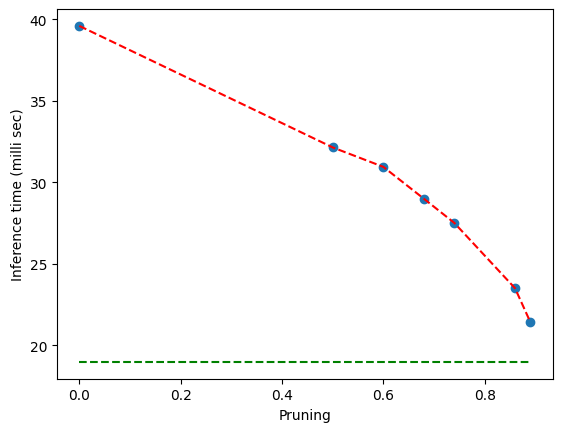

In [27]:
## Plotting stats

f1_scores = []
AP_scores = []
run_times = []
with open('kitti-main/test.txt', 'r') as f:
    len_dataset = len(f.readlines())
for ssd_model in ssd_model_list:
    f1_scores.append(F1_stats[ssd_model])
    AP_scores.append(AP_stats[ssd_model])
    run_times.append(run_time_stats[ssd_model]/len_dataset)

prune_percent = [1-float(p[1:]) for p in ssd_model_configs[1:]]
prune_percent.insert(0, 0)

plt.scatter(prune_percent, run_times)
plt.plot(prune_percent, run_times, '--', color='r')
plt.ylabel('Inference time (milli sec)')
plt.xlabel('Pruning')

run_time_yolo = run_time_stats['yolov3_tiny']/len_dataset
plt.plot(prune_percent, [run_time_yolo]*len(prune_percent), '--', color='g')



(0.0, 1.0)

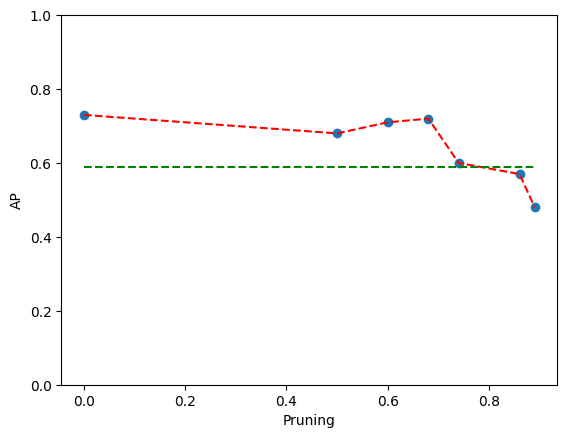

In [29]:
plt.scatter(prune_percent, AP_scores)
plt.plot(prune_percent, AP_scores, '--', color='r')
plt.plot(prune_percent, [AP_stats['yolov3_tiny']]*len(prune_percent), '--', color='g')
plt.ylabel('AP')
plt.xlabel('Pruning')
plt.ylim(0, 1)

We can see that for a minimal change in the AP scores, pruned models exhibit drastically reduced run-times! 